In [1]:
import json
import os
import numpy as np

In [2]:
def import_metrics_json(models_path, run_num):
    """
    Looks in {models_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [3]:
def get_best_metric(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value to use for
    comparison. The best metric value is determined by `metric_compare_func`, which
    must take in two arguments, and return whether or not the _first_ one is better.
    Returns the number of the run, the value associated with that run, and a dict of
    all the values used for comparison.
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_val, all_vals = None, None, {}
    for run_num in metrics.keys():
        try:
            val = reduce_func(metrics[run_num][metric_name]["values"])
            all_vals[run_num] = val
            if best_val is None or compare_func(val, best_val):
                best_val, best_run = val, run_num
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_val, all_vals

In [4]:
def get_best_metric_at_best_epoch(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value FOR EACH
    SUBARRAY/VALUE in the value array to use for comparison. The best metric value
    is determined by `metric_compare_func`, which must take in two arguments, and
    return whether or not the _first_ one is better.
    Returns the number of the run, the (one-indexed) number of the epch, the value
    associated with that run and epoch, and a dict of all the values used for
    comparison (mapping pair of run number and epoch number to value).
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_epoch, best_val, all_vals = None, None, None, {}
    for run_num in metrics.keys():
        try:
            # Find the best epoch within that run
            best_epoch_in_run, best_val_in_run = None, None
            for i, subarr in enumerate(metrics[run_num][metric_name]["values"]):
                val = reduce_func(subarr)
                if best_val_in_run is None or compare_func(val, best_val_in_run):
                    best_epoch_in_run, best_val_in_run = i + 1, val
            all_vals[(run_num, best_epoch_in_run)] = best_val_in_run
            
            # If the best value in the best epoch of the run is best so far, update
            if best_val is None or compare_func(best_val_in_run, best_val):
                best_run, best_epoch, best_val = run_num, best_epoch_in_run, best_val_in_run
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_epoch, best_val, all_vals

In [5]:
def print_validation_profile_and_prior_losses(condition):
    models_path = "/users/amtseng/att_priors/models/trained_models/profile_models/%s/" % condition
    
    print("Best profile loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_prof_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.2f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["train_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["val_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.4f" % i for i in np.mean(metrics["val_pos_att_losses"]["values"], axis=1)]))
    return all_vals

In [14]:
noprior_vals = print_validation_profile_and_prior_losses("exploring_data_dropping_1/SPI1")

Best profile loss overall:
	Best run: 13
	Best epoch in run: 5
	Associated value: 85.22217027169687
Best epoch in each run:
	Run 1, epoch 5:  86.00
	Run 2, epoch 5:  85.75
	Run 3, epoch 5:  86.44
	Run 4, epoch 5:  86.10
	Run 5, epoch 5:  85.95
	Run 6, epoch 5:  85.28
	Run 7, epoch 5:  85.34
	Run 8, epoch 5:  85.50
	Run 9, epoch 5:  85.71
	Run 10, epoch 5:  85.76
	Run 11, epoch 5:  86.04
	Run 12, epoch 5:  85.25
	Run 13, epoch 5:  85.22
All validation profile and prior losses:
1
	 91.37  86.82  86.22  85.96  85.79
	 87.56  86.77  86.35  86.20  86.00
	0.0000 0.0000 0.0000 0.0000 0.0000
2
	 91.33  86.77  86.19  85.89  85.71
	 87.38  86.54  86.04  85.98  85.75
	0.0000 0.0000 0.0000 0.0000 0.0000
3
	 93.08  87.88  86.56  86.16  85.93
	 89.12  87.51  86.85  86.62  86.44
	0.0000 0.0000 0.0000 0.0000 0.0000
4
	 91.77  87.37  86.59  86.20  85.98
	 88.13  87.14  86.68  86.20  86.10
	0.0000 0.0000 0.0000 0.0000 0.0000
5
	 90.32  86.62  86.05  85.84  85.69
	 87.42  86.48  86.17  86.00  85.95
	0.00

In [15]:
prior_vals = print_validation_profile_and_prior_losses("exploring_data_dropping_1/SPI1_prior_freqlimit160")

Best profile loss overall:
	Best run: 7
	Best epoch in run: 5
	Associated value: 85.98335747895418
Best epoch in each run:
	Run 1, epoch 4:  86.95
	Run 2, epoch 5:  86.69
	Run 3, epoch 5:  86.16
	Run 4, epoch 3:  86.89
	Run 5, epoch 5:  86.63
	Run 6, epoch 5:  86.56
	Run 7, epoch 5:  85.98
	Run 8, epoch 2:  86.75
All validation profile and prior losses:
1
	 92.18  87.24  86.73  86.50  86.33
	 88.05  87.27  87.17  86.95  86.95
	0.1640 0.0804 0.0698 0.0598 0.0566
2
	 91.01  87.23  86.89  86.71  86.58
	 87.69  87.11  87.04  87.00  86.69
	0.1529 0.0861 0.0732 0.0662 0.0583
3
	 90.60  87.11  86.77  86.63  86.51
	 87.01  86.52  86.32  86.19  86.16
	0.1602 0.0843 0.0711 0.0648 0.0610
4
	 93.79  87.74  87.04  86.77  86.60
	 88.31  87.27  86.89  86.92  86.97
	0.1677 0.0872 0.0725 0.0678 0.0617
5
	 94.11  87.37  86.86  86.65  86.55
	 87.69  86.94  86.82  86.68  86.63
	0.1541 0.0825 0.0719 0.0666 0.0610
6
	 90.98  87.23  86.77  86.56  86.41
	 87.58  87.37  87.02  86.74  86.56
	0.2059 0.0856 0.072

In [6]:
noprior_vals = print_validation_profile_and_prior_losses("SPI1_keep1")

Best profile loss overall:
	Best run: 6
	Best epoch in run: 19
	Associated value: 91.9427117948179
Best epoch in each run:
	Run 1, epoch 20:  93.40
	Run 2, epoch 20:  92.65
	Run 3, epoch 18: 105.04
	Run 4, epoch 20:  91.99
	Run 5, epoch 19:  93.78
	Run 6, epoch 19:  91.94
	Run 7, epoch 19:  94.60
	Run 8, epoch 19: 102.17
	Run 9, epoch 18:  92.81
	Run 10, epoch 19:  93.73
	Run 11, epoch 20:  95.92
	Run 12, epoch 20:  94.08
	Run 13, epoch 11:  93.98
All validation profile and prior losses:
1
	572.42 443.62 379.60 329.01 300.95 287.60 279.16 273.79 271.58 266.72 262.77 261.26 257.82 256.61 254.67 253.49 252.24 251.08 249.46 248.24
	116.58 109.75 104.72 101.59  98.59  97.74  96.95  96.22  95.53  95.39  94.91  94.62  94.49  94.12  94.16  93.98  93.71  93.79  93.66  93.40
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
2
	610.45 482.66 396.23 339.99 304.45 287.79 277.43 272.42 266.56 263.32 260.31 25

In [44]:
prior_vals = print_validation_profile_and_prior_losses("SPI1_prior_keep1_freqlimit160_limitsoft0.5")

Best profile loss overall:
	Best run: 2
	Best epoch in run: 19
	Associated value: 91.07023725156431
Best epoch in each run:
	Run 1, epoch 20:  91.89
	Run 2, epoch 19:  91.07
	Run 3, epoch 20:  92.43
	Run 4, epoch 19: 105.30
	Run 5, epoch 20:  91.96
	Run 6, epoch 20:  99.70
	Run 7, epoch 20:  98.19
	Run 8, epoch 20:  91.64
	Run 9, epoch 19:  92.28
	Run 10, epoch 20:  91.46
	Run 11, epoch 20:  91.62
All validation profile and prior losses:
1
	619.08 618.07 593.37 489.39 414.57 360.76 322.61 303.17 292.02 283.24 274.93 270.42 266.21 263.27 260.26 258.37 257.16 255.68 253.90 253.37
	121.50 121.13 118.27 116.20 107.56 102.08  99.50  98.02  97.36  95.16  94.52  94.44  93.98  93.49  92.59  92.31  92.18  91.96  91.92  91.89
	0.4167 0.3928 0.3219 0.3588 0.2896 0.2433 0.2135 0.1925 0.1707 0.1771 0.1703 0.1612 0.1604 0.1634 0.1503 0.1584 0.1489 0.1579 0.1510 0.1403
2
	616.63 517.88 432.53 384.06 345.42 306.89 291.27 281.07 275.39 268.99 265.56 261.77 259.28 257.23 255.02 254.09 252.78 251.37 250.

In [11]:
import matplotlib.pyplot as plt

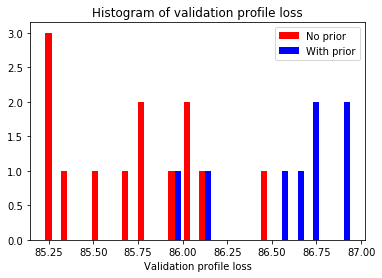

In [16]:
bin_num = 20
plt.figure()
plt.hist(
    [np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
plt.title("Histogram of validation profile loss")
plt.xlabel("Validation profile loss")
plt.legend()